# Learning a Potential

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/optim/Learn_Potential.ipynb)

In this example, we train a neural network to approxiamte a potential function $\phi(x,y)$.

In [1]:
%pip install --quiet phiflow
from phi.torch.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

We begin by defining and sampling the function $\phi(x,y) = \cos(\sqrt(x^2+y^2))$ we want to learn.

<Figure size 864x360 with 2 Axes>

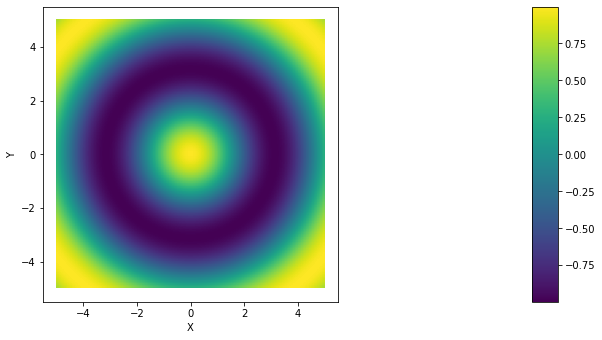

In [2]:
def potential(pos):
    return math.cos(math.vec_length(pos))

landscape = CenteredGrid(potential, x=100, y=100, bounds=Box(x=(-5, 5), y=(-5, 5)))
plot(landscape)

Next we create a fully-connected network with three hidden layers and an Adam optimizer.
We use a standard $L^2$ loss function (MSE loss) and use all sample points from the above grid as training data.

In [9]:
math.seed(0)
net = dense_net(2, 1, [32, 64, 32])
optimizer = adam(net)

def loss_function(x, label):
  prediction = math.native_call(net, x)
  return math.l2_loss(prediction - label), prediction

input_data = rename_dims(landscape.points, spatial, batch)
labels = rename_dims(landscape.values, spatial, batch)
loss_function(input_data, labels)[0]

(xᵇ=100, yᵇ=100) 0.238 ± 0.192 (1e-09...6e-01)

Let's train the network for 200 iterations!

<Figure size 288x216 with 1 Axes>

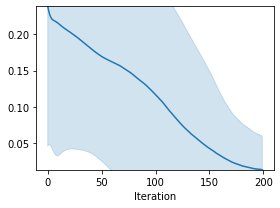

In [10]:
loss_trj = []
pred_trj = []
for i in range(200):
  loss, pred = update_weights(net, optimizer, loss_function, input_data, labels)
  loss_trj.append(loss)
  pred_trj.append(pred)
loss_trj = stack(loss_trj, spatial('iteration'))
pred_trj = stack(pred_trj, batch('iteration'))
plot(math.mean(loss_trj, 'x,y'), err=math.std(loss_trj, 'x,y'), size=(4, 3))

We can now visualize how the prediction changes during training.

In [11]:
pred_grid = rename_dims(pred_trj.iteration[::4], 'x,y', spatial)
plot(pred_grid, animate='iteration', size=(6, 5))